# Uncertainty of the Randolph Glacier Inventory (RGI) for year 2000 dataset in the context of glaciological and hydrological applications

Production date: 17-07-2024

Update: 26-01-2025

Dataset version: 6.0

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Using digitized glacier outlines and glacier extent data around the year 2000 CE for the estimation of the corresponding global glacier ice volumes and their sea level equivalent

## ❓ Quality assessment question
* **"What is the temporal distribution of the digitized glacier outlines, nominally provided for the year 2000 CE, and how well can they be used to estimate corresponding global glacier ice volumes?"**

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacier areas, glacier characteristics, as well as their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the "[Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)" (here we use version 6.0) dataset on the Climate Data Store (CDS) provides key information with respect to glacier extent and their characteristics. The RGI dataset is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 CE [[1](https://www.glims.org/RGI/randolph60.html), [2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)]. The data are available in both vector (a shapefile with polygons of individual glacier outlines) and raster (as gridded data with the aggregated fractional glacier areas per pixel) format. Although the goal of the dataset is to provide glacier outlines of all glaciers on Earth as close as possible to the year 2000, one of the main known issues of the dataset is the fact that the date of origin of the digitized glacier data varies substantially. This notebook investigates the corresponding temporal distribution of digitized glacier data in the vector version of the dataset and evaluates its implications for the estimation of current global glacier ice volumes using the example of Farinotti et al. (2019) [[3](https://www.nature.com/articles/s41561-019-0300-3)]. 

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
- The RGIv6.0 dataset, available on the Climate Data Store, is the most comprehensive source of glacier outlines globally for around the year 2000 CE. However, it has certain limitations, including variations in digitization dates (some glaciers were digitized before or after 2000 CE) and the fact that the data represent a single snapshot in time, making it unsuitable for assessing temporal changes or climate impacts. Additionally, some outlines are of poor quality, especially for debris-covered glaciers. These issues can lead to systematic errors in glacier volume estimates, with likely glacier volume and area underestimations for glaciers digitized after 2000 CE and overestimations for those digitized earlier.
- Despite these limitations, the systematic error at the global scale is small (<1% of the total global ice volume estimate by Farinotti et al. 2019), making the dataset reliable to be used as input data for current global glacier volume estimates. However, regional and glacier-specific errors can vary significantly due to factors like digitization time, glacier volume response time, and supraglacial debris cover. Users should carefully evaluate these factors for specific applications, including regional or glacier-specific volume estimates and other glaciological or hydrological analyses. 
```

## 📋 Methodology

### Dataset description

The dataset of the glaciers distribution on the Climate Data Store (CDS) is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale [[1](https://www.glims.org/RGI/randolph60.html), [2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)]. The dataset on the CDS is considered a snapshot of glacier outlines around the year 2000 CE, assembled mainly from satellite images, and is based on the Randolph Glacier Inventory (RGI), which is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of snow and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). The vector part of the dataset divides the glaciers into separate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv6.0. The raster version of the data contains aggregated fractional glacier areas for each pixel of 1 by 1 degree but does not provide sufficient information to separate glaciers into distinct RGI regions. For a more detailed description of the data acquisition and processing methods, we refer to the [documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area) (Copernicus Knowledge Base).

### Structure and (sub)sections

- Data preparation and processing
- The (area-weighted) mean year of digitization of glacier data
- An attempt to quantify potential glacier volume and area over or underestimation due to misdated outlines
- Other potential sources of error and uncertainty

## 📈 Analysis and results

### Data preparation and processing

First we load the packages:

In [1]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import cartopy.crs as ccrs
import math
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xesmf as xe
import xarray as xr
from scipy.optimize import curve_fit
import os
from c3s_eqc_automatic_quality_control import download
plt.style.use("seaborn-v0_8-notebook")

############### PLEASE DELETE THE LINE BELOW BEFORE PUBLICATION ###############
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
############### PLEASE DELETE THE LINE ABOVE BEFORE PUBLICATION ###############

Then we define requests for download from the CDS:

In [2]:
# Glacier extent data

request_extent = (
    "insitu-glaciers-extent",
    {
    "variable": ["glacier_area"],
    "product_type": ["vector"],
    "version": "rgi_6_0"
    },
)

# Glacier mass change data

period_start = "1975_1976"
period_stop = "2020_2021"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))

request_mass_change = (
    "derived-gridded-glacier-mass-change",
    {
        "variable": "glacier_mass_change",
        "product_version": "wgms_fog_2022_09",
        "format": "zip",
        "hydrological_year": [
            f"{y0}_{str(y1)[-2:]}"
            for y0, y1 in zip(
                range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1)
            )
        ],
    },
)

Next, we download the data. 

🚨 **The files can be large! Since the data files to be downloaded and manipulated have a considerable size, this may therefore take a couple of minutes.**

In [3]:
# Get glacier extent data: takes a couple of minutes

print("Downloading and handling glacier extent data from the CDS, this may take a couple of minutes...")
df = download.download_and_transform(*request_extent).to_pandas()
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["CENLON"], df["CENLAT"]),
    crs="EPSG:4326",
)

print("Downloading glacier mass change data from the CDS...")
# Get glacier mass change data
ds = download.download_and_transform(
    *request_mass_change,
)
print("Download completed.")

100%|██████████| 1/1 [00:00<00:00, 11.52it/s]
                                             

100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


Download completed.


We define the functions to be used:

In [4]:
def plot_map(gdf, var_name=None, label=None, title=None, **kwargs):
    fig = plt.figure(figsize=(20,10))
    kwargs = {"markersize": 1, "legend": var_name is not None} | kwargs
    if var_name:
        kwargs = {"c": var_name, "column": var_name} | kwargs
        if var_name == "year":
            kwargs.setdefault("legend_kwds", {"shrink": 0.49, "extend": "both"})
        if label is not None and var_name == "year":
            kwargs["legend_kwds"].setdefault("label", label)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,color='w')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gdf.plot(ax=ax, **kwargs)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=15)
    return ax

def weighted_average(df, field_name, weights_name):
    df = df[df[field_name].notnull() & df[weights_name].notnull()]
    weights = df[weights_name]
    return (df[field_name] * weights).sum() / weights.sum()

def myExpFunc(x, a, b):
    return a * np.power(x, b)

Lastly, we can read and inspect the data. Let us print out the data to inspect its structure:

In [5]:
df

,C3S_ID,RGIID,GLIMSID,BGNDATE,ENDDATE,CENLON,CENLAT,O1REGION,O2REGION,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,NAME,geometry
index,,,,,,,,,,,,,,,,,,
0,C3S_000001,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.8230,63.6890,1,2,0.360,1936,2725,2385,42.0,346,839,None,"POLYGON ((-146.81804 63.69081, -146.81768 63.6..."
1,C3S_000002,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.6680,63.4040,1,2,0.558,1713,2144,2005,16.0,162,1197,None,"POLYGON ((-146.66354 63.40764, -146.66344 63.4..."
2,C3S_000003,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.0800,63.3760,1,2,1.685,1609,2182,1868,18.0,175,2106,None,"POLYGON ((-146.07232 63.38348, -146.07232 63.3..."
3,C3S_000004,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.1200,63.3810,1,2,3.681,1273,2317,1944,19.0,195,4175,None,"POLYGON ((-146.14895 63.37919, -146.14881 63.3..."
4,C3S_000005,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.0570,63.5510,1,2,2.573,1494,2317,1914,16.0,181,2981,None,"POLYGON ((-147.04307 63.55024, -147.04483 63.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216424,C3S_216425,RGI60-19.02748,G322268E53986S,20020502,-9999999,-37.7325,-53.9860,19,3,0.042,310,510,-999,29.9,315,255,None,"POLYGON ((-37.73275 -53.98779, -37.73328 -53.9..."
216425,C3S_216426,RGI60-19.02749,G323864E54831S,20030207,-9999999,-36.1361,-54.8310,19,3,0.567,330,830,-999,23.6,200,1130,None,"POLYGON ((-36.13834 -54.82735, -36.13826 -54.8..."
216426,C3S_216427,RGI60-19.02750,G322698E54188S,20030207,-9999999,-37.3018,-54.1884,19,3,4.118,10,1110,-999,16.8,308,4329,None,"POLYGON ((-37.29309 -54.17506, -37.29308 -54.1..."


As can be seen above, the data includes attribute information for each individual glacier (i.e. digitized polygon) in the vector-type dataset. Important for this notebook are the `BGNDATE` and `ENDDATE` columns (YYYYMMDD format), which contain information about the time of digitization of the specific glacier. As can already be seen, for some glaciers (part of) these data are missing and filled by `-9999999`. We will use this information below.

### The (area-weighted) mean year of digitization of glacier data

We can begin to answer the user question by extracting information from the attribute table of the downloaded shapefile. For some glaciers the outline is composed from several scenes over multiple years implying that a begin date (attribute "`BGNDATE`") and an end date (attribute "`ENDDATE`") is given in the attribute table in YYYYMMDD format (if both are available). For these glaciers, we calculate the mean of the begin and end year:

$
year_t = \textstyle\dfrac{BGNDATE_t + ENDDATE_t}{2}\ 
$

For other glaciers, we take the `BGNDATE` only:

$
year_ t = BGNDATE_t
$

This results in the following plot:

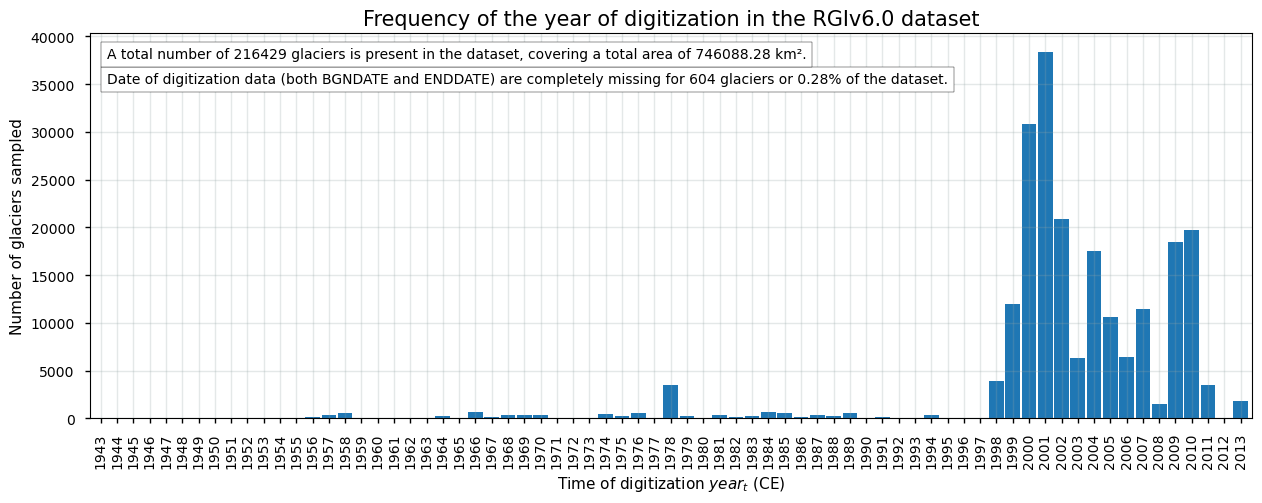

In [6]:
# Convert dates from string to datetime, and add digitalization year
columns = []
for column in ("BGNDATE", "ENDDATE"):
    years = gdf[column].str[:4]
    months = gdf[column].str[4:6].replace("99", "01")
    days = gdf[column].str[6:8].replace("99", "01")
    date = years + months + days
    date = date.where(~date.str.startswith("-"))
    columns.append(pd.to_datetime(date))
dates = pd.DataFrame(columns).mean()
year = dates.dt.year.astype("Int64")
gdf["decimal_year"] = year + (dates.dt.dayofyear - 1) / (365 + dates.dt.is_leap_year)
gdf["year"] = year

# Get data from years
size = gdf.set_index("year").groupby("year").size()
size = size.reindex(range(gdf["year"].min(), gdf["year"].max() + 1), fill_value=0)
missing = gdf["year"].isnull().sum()
missing_perc = 100 * (missing / len(gdf["year"]))
# Get some statistics
n_glaciers = len(gdf)
total_area = gdf["AREA"].sum()
# Plot data
ax = size.plot.bar(
    figsize=(15, 5),
    grid=True,
    width=0.9,
    ylabel="Number of glaciers sampled",
    xlabel=r"Time of digitization $year_t$ (CE)",
)
_ = ax.text(
    0.015,
    0.87,
    f"Date of digitization data (both BGNDATE and ENDDATE) are completely missing for {missing} glaciers or {missing_perc:.2f}% of the dataset.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
_ = ax.text(
    0.015,
    0.935,
    f"A total number of {n_glaciers} glaciers is present in the dataset, covering a total area of {total_area:.2f} km².",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_title("Frequency of the year of digitization in the RGIv6.0 dataset",fontsize=15);

*<center>Figure 1. Time of digitization for the glaciers in the glacier extent dataset (RGIv6.0).</center>*

Let us check the spatial distribution of the year of digitization for each glacier in the dataset. We therefore produce a world map where every dot represents a glacier, that is colored according to its year of digitization. Glaciers with missing data are not plotted:

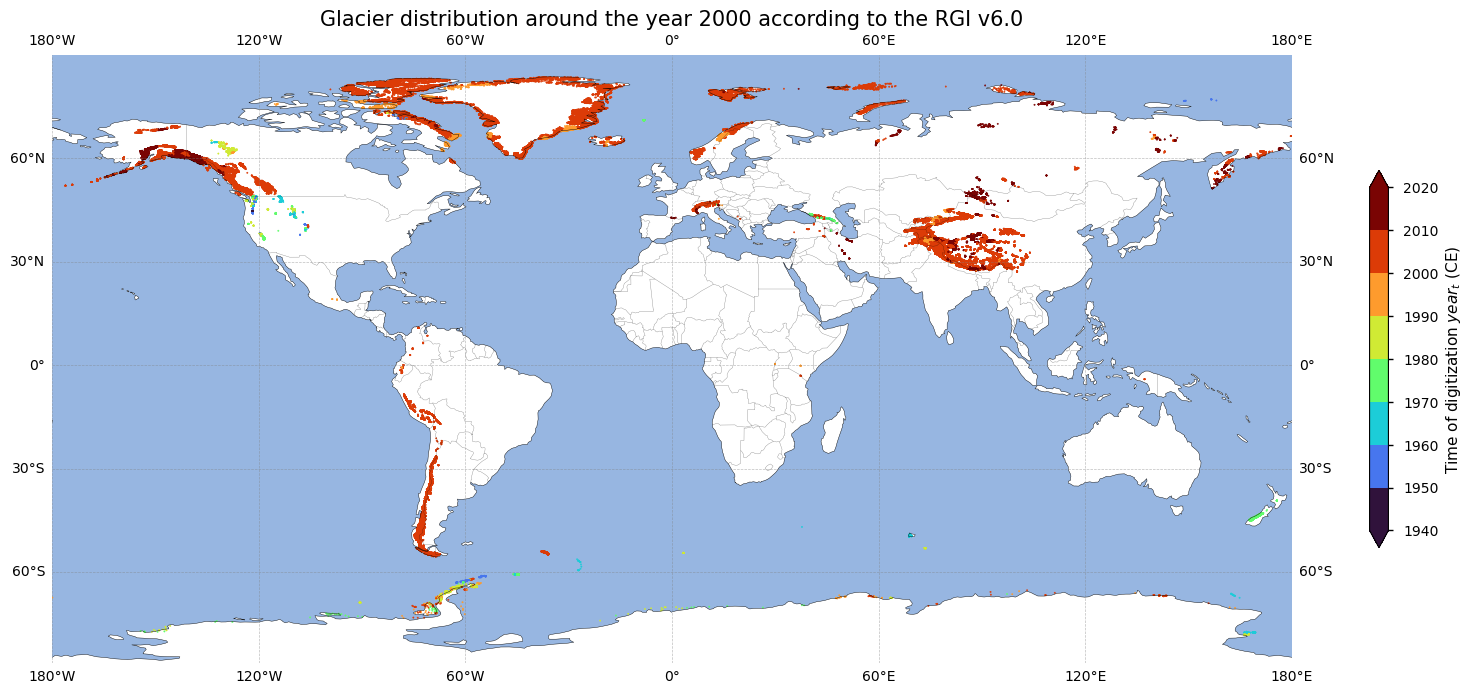

In [7]:
cmap = mpl.cm.turbo
def round_up_to_10(num):
    return math.ceil(num / 10) * 10
year2 = year.dropna()
year_rounded_up = year2.apply(round_up_to_10)
norm = mpl.colors.BoundaryNorm(range(np.min((year // 10) * 10), np.max(year_rounded_up)+1, 10), cmap.N)
ax = plot_map(
    gdf,
    var_name="year",
    cmap=cmap,
    norm=norm,
    label=r"Time of digitization $year_t$ (CE)",
    title="Glacier distribution around the year 2000 according to the RGI v6.0",
)

*<center>Figure 2. Spatial distribution of the time of digitization for the glaciers in the glacier extent dataset (RGIv6.0).</center>*

From the above plots, it becomes clear that not all glaciers are digitized in the year 2000 CE. Although the dataset is intended to be a snapshot of the world’s glaciers as they were near the beginning of the 21$^{st}$ century, the user must keep in mind that the range of digitization dates is substantial. This means that the outlines do not all lie in between the same time frame, which is a main issue of the dataset. The figures above demonstrate that most outlines originate from the period between 2000 and 2010 CE. However, for some areas like New Zealand, the Caucasus or the western United States, the glacier outlines date back to the 1970s or earlier. The user should take note of that before using a specific glacier outline. 

Let us now calculate the (area-weighted) mean time of digitization for all RGI regions:

- Arithmetic mean:
$
\overline{year}_a = \textstyle\dfrac{1}{{n\in \text{region}}}{\sum\limits_{i=1}^{n\in \text{region}} year_{t,i}}
$
with 
$
n
$
the total number of glaciers and $year_t$ the time of digitization for glacier $i$ as calculated above.

- Area-weighted mean:
$
\overline{year}_w = \left(\dfrac{1}{\sum\limits_{i=1}^{n\in \text{region}} A_i}\right) \sum\limits_{i=1}^{n\in \text{region}} \left(A_i * year_{t,i}\right)
$
where
$
A_i
$
is the glacier area for glacier $i$ [km²].

This results in the following plot:

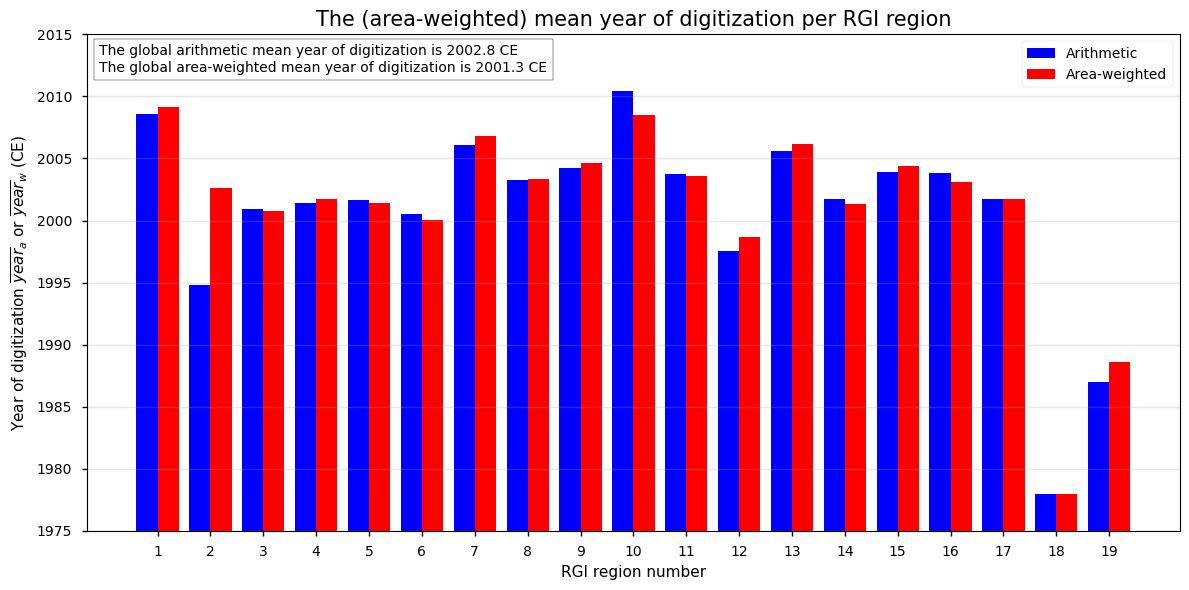

In [24]:
# Extract region number from RGIID
gdf["region"] = gdf["RGIID"].str[6:8].astype(int)

# Group by region and calculate total area
grouped = gdf[["year", "decimal_year", "AREA", "region"]].groupby("region")
ungrouped = gdf[["year", "decimal_year", "AREA", "region"]]
total_area = grouped["AREA"].sum()

# Calculate means
means = {
    "Arithmetic": grouped["decimal_year"].mean(),
    "Area-weighted": grouped.apply(
        weighted_average, "decimal_year", "AREA", include_groups=False
    ),
}

# Ensure regions are correctly defined as an array
regions = np.array(list(grouped.groups.keys()))  # Extract regions as a sorted array

# Extract the means
arithmetic_means = means["Arithmetic"]
area_weighted_means = means["Area-weighted"]

# Define bar width and positions
bar_width = 0.4
r1 = regions - bar_width / 2  # Positions for arithmetic bars
r2 = regions + bar_width / 2  # Positions for area-weighted bars

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, arithmetic_means, width=bar_width, color='blue', label='Arithmetic')
plt.bar(r2, area_weighted_means, width=bar_width, color='red', label='Area-weighted')

# Add labels, title, and legend
plt.xlabel("RGI region number")
plt.ylabel(r"Year of digitization $\overline{year}_a$ or $\overline{year}_w$ (CE)")
plt.title("The (area-weighted) mean year of digitization per RGI region", fontsize=15)
plt.xticks(regions)  # Ensure x-ticks match region numbers
plt.ylim(1975, 2015)  # Replace 1980 and 2020 with your desired range
plt.legend()

# Add text box with statistics
textstr = '\n'.join((
    'The global arithmetic mean year of digitization is %.1f CE' % (gdf["decimal_year"].mean(), ),
    'The global area-weighted mean year of digitization is %.1f CE' % (means["Area-weighted"].mean()),
))
plt.text(min(regions) - 1.1, min(arithmetic_means) + 34, textstr, bbox={"facecolor": "white", "edgecolor": "black"})

# Add grid and show plot
plt.grid(color='#95a5a6', linestyle='-', alpha=0.25, axis='y')  # Grid only on y-axis
plt.tight_layout()
plt.show()


*<center>Figure 3. Arithmetic and area-weighted mean year of digitization for the glaciers in each RGI region of the glacier extent dataset.</center>*

We observe that at the global scale, the area-weighted average of the year of digitization is close to 2001 CE, which only slightly differs in time from the nominally stated dataset reference time (i.e. 2000 CE). However, the (area-weighted) average of the time of digitization varies notably across the different RGI regions: for New Zealand (RGI region 18), for example, the area-weighted average is only 1978 CE.

### How well can the data be used to estimate current global glacier ice volumes?

#### Recent glacier area and volume change trends

Going back to our specific use case, it is worth noting that several methods exist in the literature to derive ice thickness and ice volume estimates of glaciers at different spatial scales, of which the most well-known procedures are the volume-area scaling method, numerical modelling, and the estimation of ice thicknesses from surface characteristics and the principle of ice dynamics. These methods, however, strongly rely on the precise determination of the glacier surface area (and hypsometry) as input data to derive total ice volume estimates. 

Farinotti et al. (2019), for example, used the RGIv6.0 dataset to derive a global glacier ice volume of 158.17 ± 41.03 × 10³ km³, noting the heavy reliance on accurate glacier surface area data [[3](https://www.nature.com/articles/s41561-019-0300-3)]. Other studies, including Huss and Farinotti (2012) and Marzeion et al. (2012), have similarly highlighted input data uncertainties with respect to the glacier area in ice volume estimates [[4](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JF002523), [5](https://tc.copernicus.org/articles/6/1295/2012/)]. The main concern here is that the glacierized area has decreased significantly during the last several decades, with global glacier area decreasing at rates of -0.18% to -0.34% per year and median retreat rates of 7.4 m per year [[6](https://www.cambridge.org/core/journals/journal-of-glaciology/article/historically-unprecedented-global-glacier-decline-in-the-early-21st-century/2F1E3ACB111A03F9BA83D11439F5D681), [7](https://www.sciencedirect.com/science/article/pii/S1674927820300058), [8](https://tc.copernicus.org/articles/8/659/2014/)]. These changes suggest a potential overestimation of volumes for glaciers digitized before 2000 CE and an underestimation elsewhere. The suitability of RGI outlines for current volume estimates therefore primarily depends on (1) the deviation of the time since digitization from 2000 CE and (2) the significance of glacier area/volume changes during that period, and are secondarily influenced by the local climate and specific glacier geometries.

#### An attempt to quantify potential glacier volume over or underestimation due to misdated outlines

It is difficult to quantify the potential volume over or underestimation due to misdated outlines for each glacier in the dataset. However, we can get an idea of the regional glacier  volume under/overestimation for 2000 CE by using other datasets that are available on the CDS. The goal is thus to obtain values for the regional glacier volume change between the year 2000 CE and the area-weighted mean year of digitization of that region $\overline{year}_w$ (which is thus equivalent to the potential volume over or underestimation relative to the year 2000 CE), denoted with the symbol $dV_{\text{region}}^{2000,\overline{\text{year}}_w}$. 

To get an idea of these glacier volume changes $dV_{\text{region}}^{2000,\overline{year}_w}$, we can make use of the "[Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database](https://cds.climate.copernicus.eu/datasets/derived-gridded-glacier-mass-change?tab=overview)" dataset that is on the CDS. This dataset estimates the gridded yearly mass change of glacier ice $dM/dt$ in Gt yr$^{-1}$, which can be converted to glacier volume changes $dV/dt$ with units of km$^3$ yr$^{-1}$ of ice. We therefore calculate the volume change between 2000 CE and the area-weighted average year of digitization for a certain RGI region ($\overline{year}_w$) to get a total volume change for that specific RGI region $dV_{\text{region}}^{2000,\overline{year}_w}$. If ${{\overline{year}_w}}$ is a decimal (fractional) year, we use linear interpolation to find the interpolated glacier mass and volume change: 

$ 
dV_{\text{region}}^{2000,\overline{year}_w} \text{ [km}^3\text{]} = 
\begin{cases} 
\left(\sum\limits_{i=2000}^{\lceil \overline{year}_w \rceil} \sum\limits^{\substack{\text{x,y} \\ \text{{region}}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)\right) - \\ \left[ \left( \lceil \overline{year}_w \rceil - \overline{year}_w \right) * \left( \sum\limits^{\substack{\text{x,y} \\ \text{region}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)_{\lceil \overline{year}_w \rceil} \right) \right] & \text{if } \overline{year}_w > 2000 \\ 
\left(\sum\limits_{i=\lfloor \overline{year}_w \rfloor}^{2000} \sum\limits^{\substack{\text{x,y} \\ \text{region}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)\right) - \\ \left[ \left( \overline{year}_w - \lfloor \overline{year}_w \rfloor \right) * \left( \sum\limits^{\substack{\text{x,y} \\ \text{region}}} \left(\frac{1000}{\rho_i} \frac{dM}{dt}\right)_{\lfloor \overline{year}_w \rfloor} \right) \right] & \text{if } \overline{year}_w < 2000 
\end{cases} 
$

Here, we further assume a density $\rho_i$ of 850 kg m$^{-3}$ for the mass to volume conservation of glaciers [[9](https://tc.copernicus.org/articles/7/877/2013/tc-7-877-2013.html)]. This may look like a complicated formula, but the principle is simple: for each RGI region, we simply sum the mass (and hence volume) changes over all spatial pixels between the year 2000 CE and the area-weighted year of digitization $(\overline{year}_w)$:
- If $(\overline{year}_w)$ is an integer, the second part of the formula (after the minus sign) drops out.
- If $(\overline{year}_w)$ is not an integer, the formula adjusts for the fractional part of the year:
  - If $(\overline{year}_w)$ > 2000, it uses the fraction between $(\overline{year}_w)$ and $(\lceil \overline{year}_w \rceil)$, where $\lceil \cdot \rceil$ denotes the ceiling function, which rounds a number up to the nearest integer.
  - If $(\overline{year}_w)$ < 2000, it uses the fraction between $(\lfloor \overline{year}_w \rfloor)$ and $(\overline{year}_w)$, where $\lfloor \cdot \rfloor$ denotes the floor function, which rounds a number down to the nearest integer.

Now that we have all information to derive values for $ dV_{\text{region}}^{2000,\overline{year}_w}$, let us apply this to the 19 different RGI regions in the RGIv6.0 data:

In [25]:
# Mask data for RGI regions
regions = gdf["RGIID"].str[6:8].astype(int)
da = regions.to_xarray().assign_coords(
    lon=gdf["CENLON"].to_xarray(),
    lat=gdf["CENLAT"].to_xarray(),
)
regridder = xe.Regridder(da, ds, locstream_in=True, method="nearest_s2d")
mask_2d = regridder(da)
mask = xr.concat(
    [(mask_2d == region).expand_dims(region=[region]) for region in regions.unique()],
    "region",
)
ds = ds.where(mask)

# Compute cumulative fields
ds["time"] = ds["time"].dt.year
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Mass change
cumulative = (ds["Glacier"].sum(("latitude","longitude"),keep_attrs=True)).cumsum("time")
cumulative.attrs = {
    "units": ds["Glacier"].attrs["units"].split()[0],
    "long_name": f"Cumulative {ds['Glacier'].attrs['long_name']}",
}
ds["Cumulative"] = cumulative
    
# Calculate volume under or overestimation
year = 2000
original = ds.reset_coords()["Cumulative"]
interpolated = original.interp(time=means["Area-weighted"].to_xarray())
estimate = (1/0.850) * (interpolated - original.sel(time=year)).compute()
# Do the loop
for region, result in zip(estimate.region.values, estimate.values):
    print(
        f"The volume estimate in RGI region {region:>2}"
        f" for the year {year} CE is"
        f" {'under' if result < 0 else 'over':>5}estimated"
        f" by {abs(float(result)):.2f} km³."
    )

total = estimate.sum()
print(
    f"\nThe volume estimate at the global scale"
    f" for the year {year} CE is"
    f" {'under' if result <0 else 'over'}estimated"
    f" by {abs(float(total)):.2f} km³."
)

The volume estimate in RGI region  1 for the year 2000 CE is underestimated by 599.82 km³.
The volume estimate in RGI region  2 for the year 2000 CE is underestimated by 25.83 km³.
The volume estimate in RGI region  3 for the year 2000 CE is underestimated by 14.31 km³.
The volume estimate in RGI region  4 for the year 2000 CE is underestimated by 32.56 km³.
The volume estimate in RGI region  5 for the year 2000 CE is underestimated by 50.51 km³.
The volume estimate in RGI region  6 for the year 2000 CE is underestimated by 0.09 km³.
The volume estimate in RGI region  7 for the year 2000 CE is underestimated by 100.18 km³.
The volume estimate in RGI region  8 for the year 2000 CE is underestimated by 12.76 km³.
The volume estimate in RGI region  9 for the year 2000 CE is underestimated by 78.40 km³.
The volume estimate in RGI region 10 for the year 2000 CE is underestimated by 11.96 km³.
The volume estimate in RGI region 11 for the year 2000 CE is underestimated by 5.30 km³.
The volume

Or when plotted:

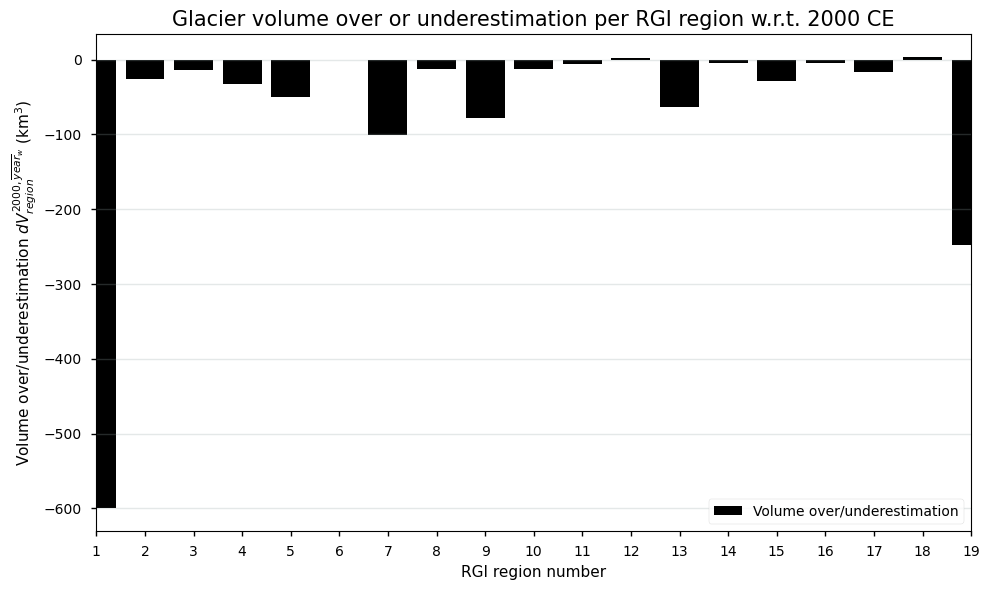

In [27]:
# Define regions
regions = np.arange(1, max(gdf["region"]) + 1)  # Create an array of region numbers
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(regions, estimate.values, color='black', label='Volume over/underestimation')
# Set plot labels and title
ax.set_xlabel("RGI region number")
ax.set_ylabel("Volume over/underestimation $dV_{{region}}^{2000,\overline{year}_w}$ (km$^3$)")
ax.set_title("Glacier volume over or underestimation per RGI region w.r.t. 2000 CE", fontsize=15)
# Set x-ticks, grid, and x-limits
ax.set_xticks(regions)  # Ensure x-ticks match the region numbers
ax.grid(color='#95a5a6', linestyle='-', alpha=0.25, axis='y')  # Add gridlines only on the y-axis
ax.set_xlim(1, max(regions))  # Adjust the x-axis limits to match region numbers
# Add legend (optional)
ax.legend()
# Show the plot
plt.tight_layout()
plt.show()

*Figure 4. Total volume over or underestimation compared to the year 2000 CE for the glaciers in each RGI region of the glacier extent dataset (RGv6.0).*

In the plot above, negative values indicate an underestimation. It is clear that especially RGI regions 1 (Alaska) and 19 (Antarctic and Subantarctic) exhibit a relatively large underestimation of the total glacier ice volume, mainly due to their large deviation of the  area-weighted average year of digitization to the year 2000 CE, as well as the large glacier ice volume changes during this corresponding period. At the global scale, glacier ice volume estimates would exhibit an underestimation of ca. 1300 km³ due to misdated glacier outlines, which is only ca. 0.8% of the total glacier ice volume estimate by Farinotti et al. (2019). Glacier ice volumes are only overestimated in RGI regions 12 (Caucasus and Middle East) and 18 (New Zealand). Percentage-wise, the highest deviation relative to the total glacier ice volume in a certain region occurs in RGI region 10 (North Asia ~ in the order of 8%). At the global scale, the above obtained deviation related to the misdated glacier outlines from RGIv6.0 is thus relatively low when compared to the total global glacier ice volume estimate from Farinotti et al. (2019), implying that the dataset is well-suited to estimate current global glacier ice volumes for the year 2000 CE. The corresponding systematic error is, however, glacier- and region-dependent.

### Other potential sources of error and uncertainty

Several additional factors contribute to the uncertainty in glacier data derived from the RGI dataset. These include low-resolution and poor-quality source data, errors by digitizers, and challenges such as shadows, clouds, proglacial lakes, seasonal snowfields, and limited multi-temporal satellite imagery. The most significant source of misdelineation is supraglacial debris, which often results in glacier area underestimation in regions with extensive debris cover (e.g. High Mountain Asia and the Caucasus), due to the spectral similarity between debris and surrounding moraines or bedrock [[10](https://www.cambridge.org/core/journals/annals-of-glaciology/article/on-the-accuracy-of-glacier-outlines-derived-from-remotesensing-data/D9EF9B9A26CEF34970C4F4924C19CE93)]. Additionally, ice bodies smaller than 0.01 km², considered below the threshold for ice flow, were excluded, leading to further underestimation of glacier area in some regions [[1](https://www.glims.org/RGI/randolph60.html)].

The interpretation of what constitutes a glacier also varies due to the diverse global community that contributed to the dataset, causing inconsistencies in how features like debris-covered glaciers, tributaries, and peripheral ice bodies in Antarctica and Greenland were handled [[11](https://www.cambridge.org/core/journals/journal-of-glaciology/article/what-is-the-global-glacier-ice-volume-outside-the-ice-sheets/AB9CE3BDB3741B44B6A2A94FAB28A83B)]. For example, distinguishing debris-covered ice from bedrock or separating outlet glaciers from main ice sheets remains problematic. In RGI regions 14 and 15 (South Asia West and East), significant underestimation is evident in the gridded version of the dataset compared to the vector counterpart, with errors exceeding 50% in South Asia East [[12](https://www.cambridge.org/core/journals/journal-of-glaciology/article/new-global-gridded-glacier-dataset-based-on-the-randolph-glacier-inventory-version-60/621E15FFA80C8B0612146022A7197AC5)].

Quantitative error estimates are not provided in the dataset, but [[2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)] noted that relative errors are higher for small glaciers due to their larger outline-to-area ratio. Consequently, the uncertainty in an individual glacier outline depends on the quality of the source material and the specific glacier's characteristics, even for outlines assumed to represent 2000 CE. Users should exercise caution, particularly in regions with significant debris cover or small glacier features.

## ℹ️ If you want to know more

### Key resources

- [Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area)
- [Copernicus climate change indicators: glaciers](https://climate.copernicus.eu/climate-indicators/glaciers)
- [RGI website from GLIMS](https://www.glims.org/RGI/) (Global Land Ice Measurements from Space)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [BOpen](https://www.bopen.eu).

### References

- [[1](https://www.glims.org/RGI/randolph60.html)] RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- [[2](https://www.cambridge.org/core/journals/journal-of-glaciology/article/randolph-glacier-inventory-a-globally-complete-inventory-of-glaciers/730D4CC76E0E3EC1832FA3F4D90691CE)] Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

- [[3](https://www.nature.com/articles/s41561-019-0300-3)] Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

- [[4](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JF002523)] Huss, M., and Farinotti, D. (2012). Distributed ice thickness and volume of all glaciers around the globe, Journal of Geophysical Research, 117, F04010. doi: 10.1029/2012JF002523.

- [[5](https://tc.copernicus.org/articles/6/1295/2012/)] Marzeion, B., Jarosch, A. H., and Hofer, M. (2012). Past and future sea-level change from the surface mass balance of glaciers, The Cryosphere, 6, 1295–1322. doi: 10.5194/tc-6-1295-2012.

- [[6](https://www.cambridge.org/core/journals/journal-of-glaciology/article/historically-unprecedented-global-glacier-decline-in-the-early-21st-century/2F1E3ACB111A03F9BA83D11439F5D681)] Zemp, M., Frey, H., Gärtnew-Roer, I., Nussbaumer, S. U., Helzle, M., Paul, F., Haeberli, W., Denzinger, F., Ahlstrøm, A. P., Anderson, B., Bajracharya, S., Baroni, C., Braun, L. N., Cáceres, B. E., Casassa, G., Cobos, G., Dávila, L. R., Delgado Granados, H., Demuth, M. N., Espizua, L., Fischer, A., Fujita, K., Gadek, B., Ghazanfar, A., Hagen, J. O., Holmlund, P., Karimi, N., Li, Z., Pelto, M., Pitte, P., Popovnin, V. V., Portocarrero, C. A., Prinz, R., Sangewar, C. V., Severskiy, I., Sigurdsson, O., Soruco, A., Usubaliev, R., and Vincent, C. (2015). Historically unprecedented global glacier decline in the early 21st century, Journal of Glaciology, 61, 745-762. doi: 10.3189/2015JoG15J017.

- [[7](https://www.sciencedirect.com/science/article/pii/S1674927820300058)] Li, Y. J., Ding, Y. J., Shangguan, D. H., and Wang, R. J. (2019). Regional differences in global glacier retreat from 1980 to 2015, Advances in Climate Change Research, 10(4), 203–213. doi: 10.1016/j.accre.2020.03.003.

- [[8](https://tc.copernicus.org/articles/8/659/2014/)] Leclercq, P. W., Oerlemans, J., Basagic, H. J., Bushueva, I., Cook, A. J., and Le Bris, R. (2014). A data set of worldwide glacier length fluctuations, Cryosphere, 2014(8), 659–672. doi: 10.5194/tc-8-659-2014.

- [[9](https://tc.copernicus.org/articles/7/877/2013/tc-7-877-2013.html)] Huss, M. (2013). Density assumptions for converting geodetic glacier volume change to mass change, The Cryosphere, 7, 877–887, doi: 10.5194/tc-7-877-2013.

- [[10](https://www.cambridge.org/core/journals/annals-of-glaciology/article/on-the-accuracy-of-glacier-outlines-derived-from-remotesensing-data/D9EF9B9A26CEF34970C4F4924C19CE93)] Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

- [[11](https://www.cambridge.org/core/journals/journal-of-glaciology/article/what-is-the-global-glacier-ice-volume-outside-the-ice-sheets/AB9CE3BDB3741B44B6A2A94FAB28A83B)] Hock, R., Maussion, F., Marzeion, B., and Nowicki, S. (2022). What is the global glacier ice volume outside the ice sheets? Journal of Glaciology, 69(273), 204–10. doi: 10.1017/jog.2023.1.

- [[12](https://www.cambridge.org/core/journals/journal-of-glaciology/article/new-global-gridded-glacier-dataset-based-on-the-randolph-glacier-inventory-version-60/621E15FFA80C8B0612146022A7197AC5)] Li, Y. J., Li, F., Shangguan, D. H., Ding, Y. J. (2021). A New Global Gridded Glacier Dataset Based on the Randolph Glacier Inventory Version 6.0. Journal of Glaciology, 67 (2021), 773–76. doi: 10.1017/jog.2021.28.